In [1]:
from pnpl.datasets import LibriBrainSpeech
from torch.utils.data import DataLoader

base_path = "."

data = LibriBrainSpeech(
    data_path = f"{base_path}/data/",
    include_run_keys = [("0", "1", "Sherlock1", "1")],
    tmin = 0.0,
    tmax = 0.8,
    preload_files = True
)

loader = DataLoader(data, batch_size=8, shuffle=True, num_workers=0)

print(f"Number of samples in dataset: {len(data)}")

Number of samples in dataset: 1373


/home/phuong/miniconda3/envs/aienv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Explore H5 File

In [2]:
import h5py
import numpy as np

hdf5_file_path = f"{base_path}/data/Sherlock1/derivatives/serialised/sub-0_ses-1_task-Sherlock1_run-1_proc-bads+headpos+sss+notch+bp+ds_meg.h5"

with h5py.File(hdf5_file_path, "r") as f:
    print("-----File Structure-----")
    def print_structure(name, obj):
        obj_type = "Group" if isinstance(obj, h5py.Group) else "Dataset"
        print(f"{name} ({obj_type})")
    f.visititems(print_structure)
    for key in f.keys():
        obj = f[key]
        print(f"\n------Contents of '{key}'------")
        print("Type:", "Group" if isinstance(obj, h5py.Group) else "Dataset")
        if hasattr(obj, 'shape'):
            print("Shape:", obj.shape)
            print("Data type: ", obj.dtype)
    data = f["data"][:]
    times = f["times"][:]
    
# print first 5 sameples of data and times
print("\nFirst 5 samples of 'data':")
print(data[:5])
print("\nFirst 5 samples of 'times':")
print(times[:5])

-----File Structure-----
data (Dataset)
times (Dataset)

------Contents of 'data'------
Type: Dataset
Shape: (306, 278000)
Data type:  float32

------Contents of 'times'------
Type: Dataset
Shape: (278000,)
Data type:  float32

First 5 samples of 'data':
[[-3.5874353e-17 -2.1509460e-13  9.2436936e-14 ...  5.1477390e-12
   4.2755088e-12  5.1459852e-12]
 [ 5.3139814e-16  4.3802184e-12  2.1201580e-12 ...  3.1967601e-10
   2.7351199e-10  3.4351191e-10]
 [ 7.0220260e-16  2.2623589e-12  3.7938021e-12 ... -3.3079589e-10
  -2.8242153e-10 -3.6344866e-10]
 [-4.2772385e-17 -2.9027781e-13 -1.6250738e-13 ...  9.0799234e-12
   7.5959699e-12  9.5465172e-12]
 [-8.7409930e-16 -2.7950125e-12  6.7976232e-12 ...  8.5350893e-11
   7.6355866e-11  9.3201370e-11]]

First 5 samples of 'times':
[0.    0.004 0.008 0.012 0.016]


### Explore TSV File

In [3]:
import pandas as pd

def type_tsv(series):
    if series.dtype in ['float64', 'int64']:
        return (f"Series(dtype={series.dtype}, min={series.min()}, max={series.max()}, mean={series.mean():.3e}, std={series.std():.3e})")
    elif series.dtype == 'object':
        unique_values = series.unique()
        return (f"Series(dtype={series.dtype}, num_unique_values={len(unique_values)}, unique_values={unique_values})")
    else: 
        return (f"Series(dtype={series.dtype})")

def explore_tsv(file_path):
    data = pd.read_csv(file_path, sep="\t")
    print(f"-----Exploring TSV File-----")
    print(f"Number of rows: {data.shape[0]}")
    print(f"Number of columns: {data.shape[1]}")
    
    print(f"\n-----Column Details-----")
    for column in data.columns:
        print(f"{column}: {type_tsv(data[column])}")
        
    print(f"\n-----First 10 Rows-----")
    print(data.head(10))

tsv_file_path = f"{base_path}/data/Sherlock1/derivatives/events/sub-0_ses-1_task-Sherlock1_run-1_events.tsv"
explore_tsv(tsv_file_path)

-----Exploring TSV File-----
Number of rows: 12806
Number of columns: 12

-----Column Details-----
idx: Series(dtype=int64, min=1, max=12806, mean=6.404e+03, std=3.697e+03)
wavile: Series(dtype=object, num_unique_values=1, unique_values=['segments/'])
kind: Series(dtype=object, num_unique_values=3, unique_values=['silence' 'word' 'phoneme'])
segment: Series(dtype=object, num_unique_values=1152, unique_values=[nan 'A' 'ah_S' ... 'acquaintance' 'End' 'chapter'])
sentenceidx: Series(dtype=float64, min=0.0, max=187.0, mean=8.266e+01, std=5.399e+01)
wordidx: Series(dtype=float64, min=0.0, max=41.0, mean=1.018e+01, std=8.414e+00)
phonemeidx: Series(dtype=float64, min=0.0, max=12.0, mean=1.791e+00, std=1.918e+00)
timemeg: Series(dtype=float64, min=28.772, max=1098.558, mean=5.645e+02, std=3.073e+02)
timeds: Series(dtype=float64, min=28.772, max=1098.556, mean=5.645e+02, std=3.073e+02)
timechapter: Series(dtype=float64, min=0.0, max=1064.6840000000002, mean=5.334e+02, std=3.058e+02)
timesenten

Creating RawArray with float64 data, n_channels=306, n_times=278000
    Range : 0 ... 277999 =      0.000 ...  1111.996 secs
Ready.


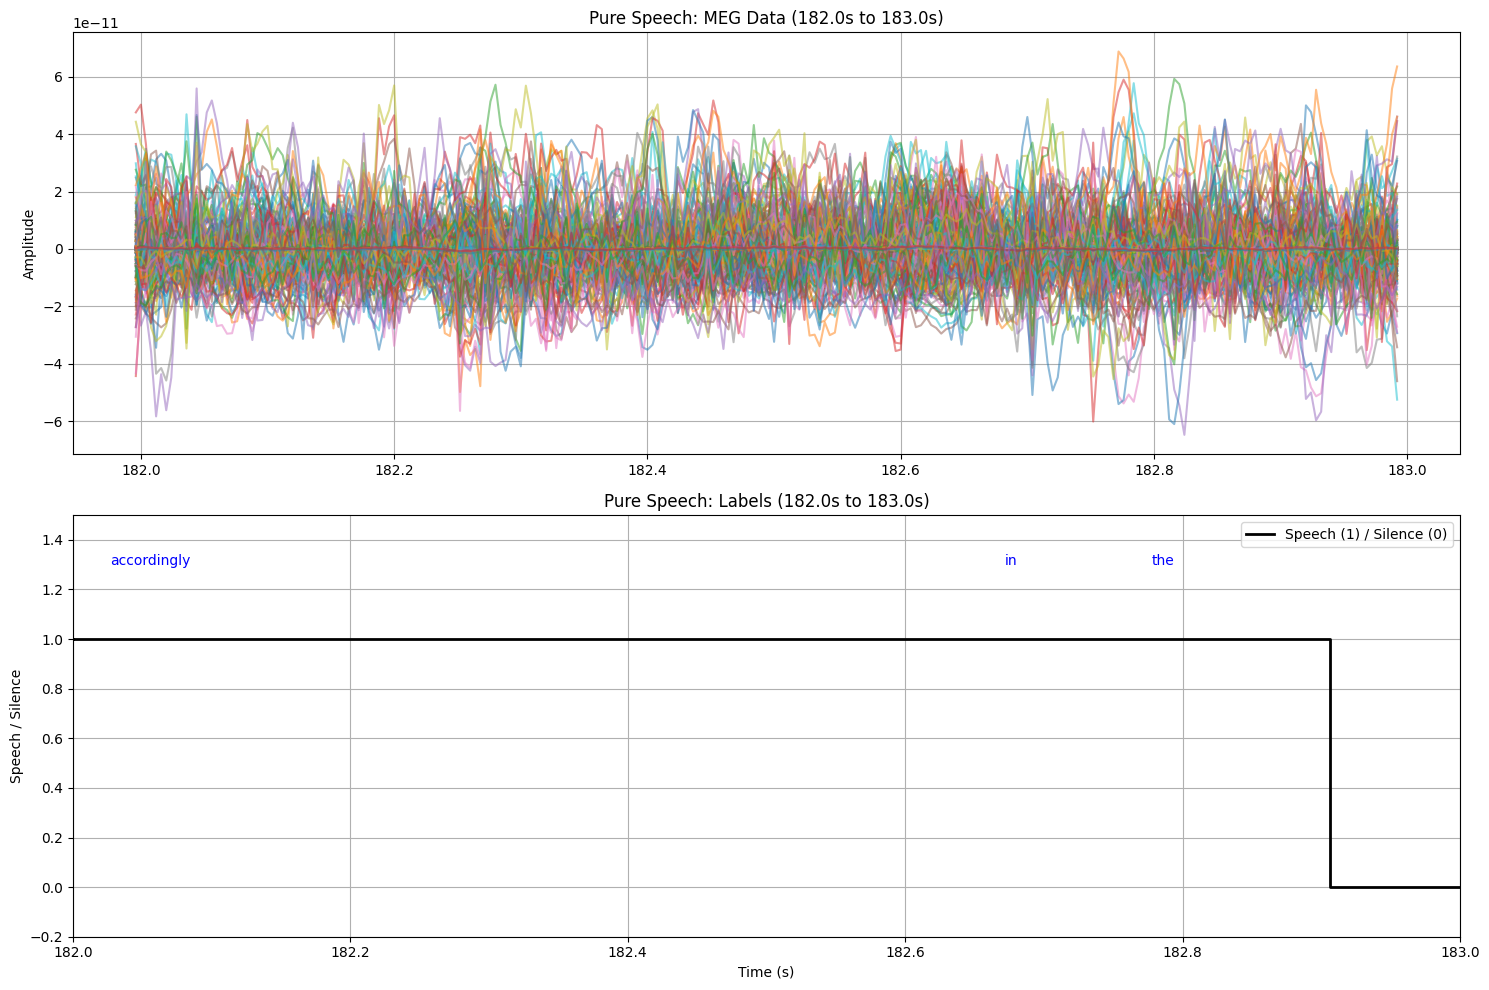

In [5]:
from matplotlib.pyplot import title
import pandas as pd
import h5py
import mne

def load_meg_data(hdf5_file_path):
    with h5py.File(hdf5_file_path, "r") as f:
        data = f["data"][:]
        times = f["times"][:]
    if len(times) >= 2:
        sfreq = 1.0 / (times[1] - times[0])
    else:
        raise ValueError("Not enough time points to calculate sampling frequency.")
    n_channels = data.shape[0]
    ch_names = [f"MEG {str(i).zfill(3)}" for i in range(n_channels)]
    
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=["mag"] * n_channels)
    
    raw_object = mne.io.RawArray(data, info)
    return raw_object

def label_visualization(tsv_file, raw_mne, start_time=10.0, end_time=11.0, title=None,show_phonemes=False, apply_sensor_mask=False):
    if apply_sensor_mask:
        try:
            raw_mne = raw_mne.copy().pick(SENSORS_SPEECH_MASK)
        except NameError:
            print("SENSORS_SPEECH_MASK is not defined. Proceeding without sensor mask.")
            
    data = tsv_file.copy()
    before_start_time = data[data['timemeg'] < start_time].iloc[-1:]
    window = data[(data['timemeg'] >= start_time) & (data['timemeg'] <= end_time)]
    filtered_data = pd.concat([before_start_time, window]).sort_values('timemeg')
    if filtered_data.empty:
        filtered_data = pd.DataFrame(
            {
                'timemeg':[start_time, end_time],
                'speech_label': [0, 0]
            }
        )
    filtered_data['speech_label'] = 0
    filtered_data.loc[filtered_data['kind'].isin(['word', 'phoneme']), 'speech_label'] = 1
    
    first_value = filtered_data.iloc[0]['speech_label']
    plot_times = [start_time]
    plot_values = [first_value]
    plot_times.extend(filtered_data['timemeg'].tolist())
    plot_values.extend(filtered_data['speech_label'].tolist())
    plot_times.append(end_time)
    plot_values.append(plot_values[-1])
    plot_times = np.array(plot_times)
    plot_values = np.array(plot_values)
    
    # Extract data segment
    start_sample = int(start_time * raw_mne.info['sfreq'])
    end_sample = int(end_time * raw_mne.info['sfreq'])
    meg_segment, time_points = raw_mne.get_data(
        start = start_sample,
        stop = end_sample,
        return_times = True
    )
    
    # Plotting
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(2, 1, figsize=(15, 10))
    meg_title = f"{title}: MEG Data ({start_time}s to {end_time}s)" if title else f"MEG Data ({start_time}s to {end_time}s)"
    axs[0].plot(time_points, meg_segment.T, alpha=0.5)
    axs[0].set_title(meg_title)
    axs[0].set_ylabel('Amplitude')
    axs[0].grid(True)

    axs[1].plot(plot_times, plot_values, drawstyle='steps-post', label='Speech (1) / Silence (0)',
                linewidth=2, color='black')
    for _, row in filtered_data.iterrows():
        if pd.isna(row['kind']) or row['kind'] == 'silence':
            continue
        if pd.isna(row['timemeg']) or pd.isna(row['segment']):
            continue
        try:
            if row['kind'] == 'phoneme' and show_phonemes and start_time <= row['timemeg'] <= end_time:
                axs[1].text(row['timemeg'], 1.1, str(row['segment']), fontsize=9, rotation=45, ha='center')
            elif row['kind'] == 'word' and start_time <= row['timemeg'] <= end_time:
                axs[1].text(row['timemeg'], 1.3, str(row['segment']), fontsize=10, rotation=0, ha='center', color='blue')
        except Exception as e:
            print(f"Warning: Could not plot annotation at time {row['timemeg']}: {e}")

    axs[1].set_ylabel('Speech / Silence')
    labels_title = f"{title}: Labels ({start_time}s to {end_time}s)" if title else f"Labels ({start_time}s to {end_time}s)"
    axs[1].set_title(labels_title)
    axs[1].set_ylim(-0.2, 1.5)
    axs[1].set_xlim(start_time, end_time)
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_xlabel('Time (s)')

    plt.tight_layout()
    plt.show()
    

tsv_file_path = f"{base_path}/data/Sherlock1/derivatives/events/sub-0_ses-1_task-Sherlock1_run-1_events.tsv"
hdf5_file_path = f"{base_path}/data/Sherlock1/derivatives/serialised/sub-0_ses-1_task-Sherlock1_run-1_proc-bads+headpos+sss+notch+bp+ds_meg.h5"

tsv_file = pd.read_csv(tsv_file_path, sep="\t")
raw_mne = load_meg_data(hdf5_file_path)

label_visualization(tsv_file, raw_mne, start_time=182.0, end_time=183.0, title="Pure Speech")

### Train model

In [ ]:
from pnpl.datasets import LibriBrainSpeech
from torch.utils.data import DataLoader

train_run_keys = [("0", str(i), "Sherlock1", "1") for i in range(1, 11)]
train_data = LibriBrainSpeech(
    data_path = f"{base_path}/data/",
    include_run_keys = train_run_keys,
    tmin = 0.0,
    tmax = 0.8,
    preload_files = True
)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=0)

val_data = LibriBrainSpeech(
    data_path = f"{base_path}/data/",
    include_run_keys = [("0", "11", "Sherlock1", "2")],
    tmin = 0.0,
    tmax = 0.8,
    preload_files = True,
    standardize = True
)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=0)

test_data = LibriBrainSpeech(
    data_path = f"{base_path}/data/",
    include_run_keys = [("0", "12", "Sherlock1", "2")],
    tmin = 0.0,
    tmax = 0.8,
    preload_files = True,
    standardize = True
)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=0)

print(f"Number of training samples: {len(train_data)}")
print(f"Number of validation samples: {len(val_data)}")
print(f"Number of test samples: {len(test_data)}")